In [80]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob
import numpy as np

In [81]:
sns.set_theme(context = 'notebook')

In [148]:
qaoa_files = glob('pennylane/results/04-09-2023/*qaoa*.csv')
qaoa_files += glob('pennylane/results/02-09-2023/*qaoa*.csv')
qaoa_files += glob('pennylane/results/01-09-2023/*qaoa*.csv')
qaoa_files += glob('quop/results/05-09-2023/*qaoa*.csv')
qaoa_df = [pd.read_csv(f) for f in qaoa_files]
qaoa_df = [df for df in qaoa_df if len(df) == 0]
qaoa_df = pd.concat([pd.read_csv(f) for f in qaoa_files])

qaoa_df.loc[(qaoa_df['n_gpus'] ==1) & (qaoa_df['backend'] == 'lightning.kokkos'), ['backend']]= 'lightning.kokkos (HIP)'
qaoa_df.loc[qaoa_df.backend =='lightning.kokkos', ['backend']]= 'lightning.kokkos (OpenMP)'
qaoa_df.loc[qaoa_df.backend =='lightning.kokkos', ['backend']]= 'lightning.kokkos (OpenMP)'


for backend in qaoa_df['backend'].unique():
    print(backend)

lightning.qubit
default.qubit
qiskit.aer
lightning.kokkos (HIP)
lightning.kokkos (OpenMP)
wavefront


In [258]:
depth = 32

def OpenMP_plot(ax, depth, backend, efficiency = False, legend_title_pad = 0.08, max_qubits = 24):
    lightning_kokkos_openmp_df = qaoa_df[(qaoa_df['backend'] == backend) & (qaoa_df['depth'] == depth)]

    single_core_df = lightning_kokkos_openmp_df[lightning_kokkos_openmp_df['n_cpus'] == 1]
    single_core_wall_time = single_core_df.groupby(['qubits'])['wall_time'].mean()
    single_core_qubits = single_core_df.groupby(['qubits'])['qubits'].mean()
    single_core_dict = {qubit: wall_time for qubit, wall_time in zip(single_core_qubits, single_core_wall_time)}

    for i, n_cpus in enumerate(lightning_kokkos_openmp_df['n_cpus'].unique()):

        if n_cpus == 1:
            continue

        n_cpus_df = lightning_kokkos_openmp_df[lightning_kokkos_openmp_df['n_cpus'] == n_cpus]
        wall_time = n_cpus_df.groupby(['qubits'])['wall_time'].mean()
        qubits = n_cpus_df.groupby(['qubits'])['qubits'].mean()
        results_dict = {qubit: wall_time for qubit, wall_time in zip(qubits, wall_time)}
        plot_qubits = []
        plot_speedup = []
        for qubits in set(results_dict.keys()).intersection(single_core_dict.keys()):
            if efficiency:
                plot_speedup.append(single_core_dict[qubits]/(results_dict[qubits]*n_cpus))
            else:
                plot_speedup.append(single_core_dict[qubits]/results_dict[qubits])
            plot_qubits.append(qubits)
        ax.plot(plot_qubits, plot_speedup, '--', marker = markers[i], label = f'{n_cpus}', color = f'C{i}')

    ax.set_title(f'Depth: {depth}')
    ax.set_xticks([i for i in range(12, max_qubits + 1, 2)])
    ax.set_xlim(11.5, max_qubits + 0.5)


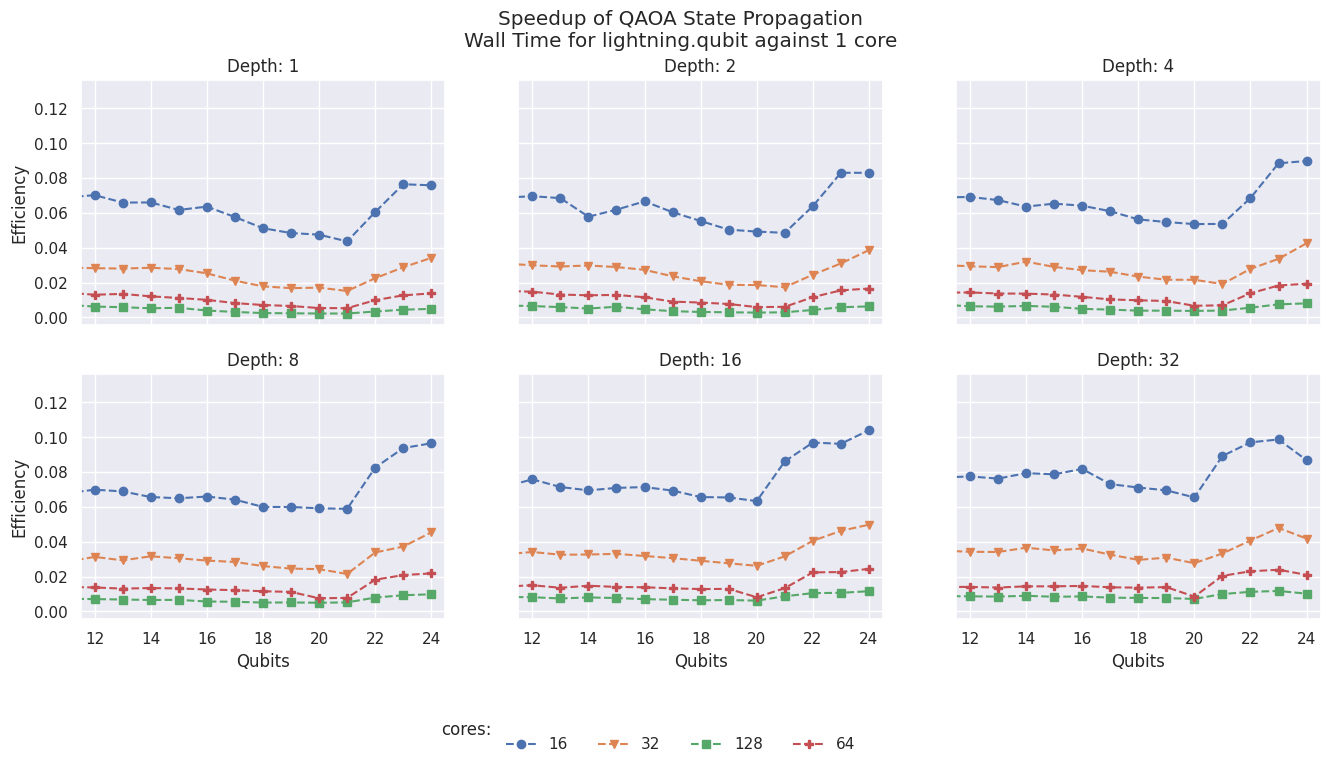

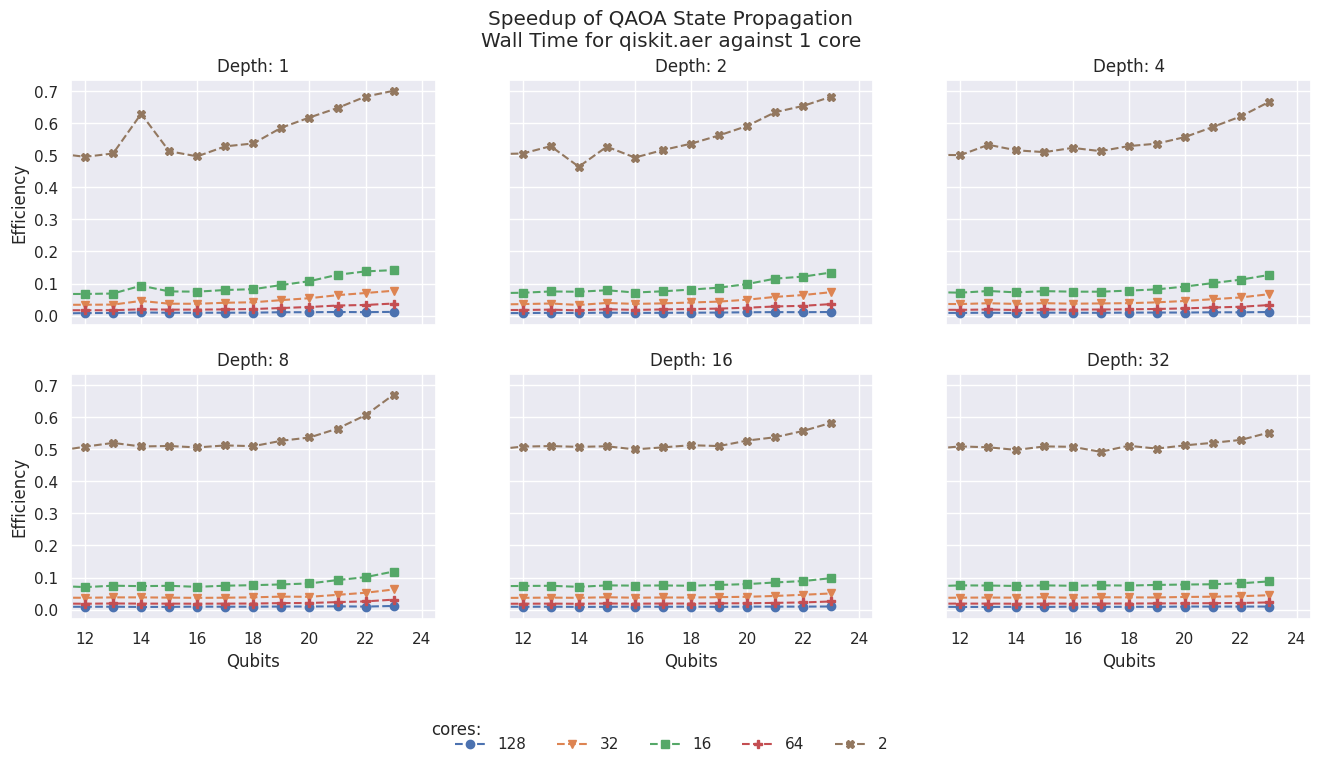

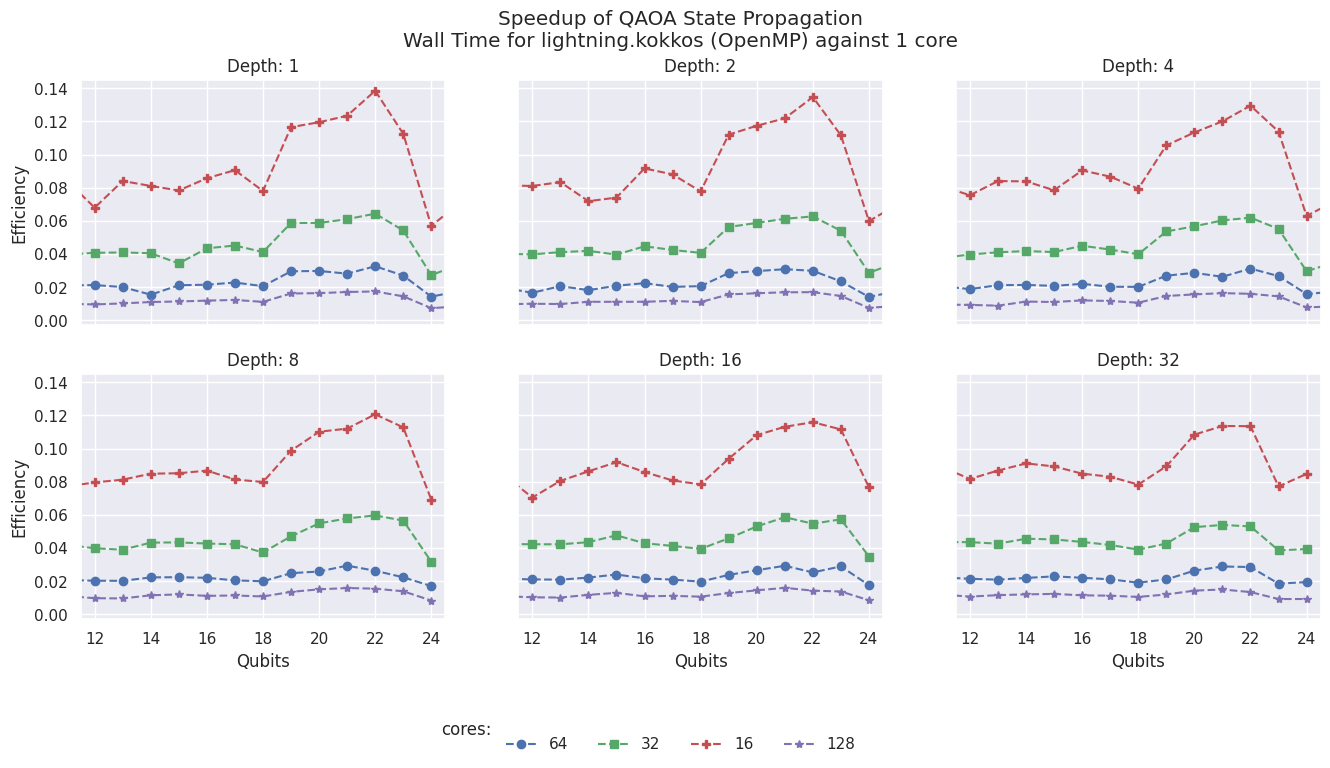

In [304]:
for backend in qaoa_df['backend'].unique():
    if qaoa_df.loc[qaoa_df['backend'] == backend]['n_cpus'].unique().shape[0] == 1:
        continue
    fig, axes = plt.subplots(2, 3, figsize=(16, 7), sharex=True, sharey=True)
    depths = [1, 2, 4, 8, 16, 32]
    for depth, ax in zip(depths, axes.reshape(-1)):
        OpenMP_plot(ax, depth, backend, efficiency = True)
    for i in range(axes.shape[0]):
        axes[i,0].set_ylabel('Efficiency')
    for i in range(axes.shape[1]):
        axes[-1,i].set_xlabel('Qubits')

    fig.suptitle(f'Speedup of QAOA State Propagation\nWall Time for {backend} against 1 core')

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')
    sns.move_legend(fig, "lower center", bbox_to_anchor=(0.5, -0.1), ncol=5, frameon=False)
    caption="cores:"
    plt.figtext(0.35, -0.0555, caption, wrap=True, horizontalalignment='left', fontsize=12)

    plt.show()

In [306]:
def walltime_plot(ax, depth, config = None, efficiency = False, legend_title_pad = 0.08, max_qubits = 25):

    for i, backend in enumerate(qaoa_df['backend'].unique()):
        if ((backend == 'lightning.qubit') or (backend == 'lightning.kokkos (OpenMP)')) or (backend == 'qiskit.aer'):
            backend_df = qaoa_df[qaoa_df['backend'] == backend]
            backend_df = backend_df[backend_df['n_cpus']==cores]
        else:
            backend_df = qaoa_df[qaoa_df['backend'] == backend]
        depth_df = backend_df[backend_df['depth']==depth]
        wall_time = depth_df.groupby(['qubits'])['wall_time'].mean()
        qubits = depth_df.groupby(['qubits'])['qubits'].mean()
    
        ax.plot(qubits, wall_time, '--', marker = markers[i], label = f'{backend} ({extra_info[backend][0]})', color = f'C{i}')
    ax.set_yscale('log')
    ax.set_title(f'Depth: {depth}')
    ax.set_xticks([i for i in range(12, max_qubits + 1, 2)])
    ax.set_xlim(11.5, max_qubits + 0.5)




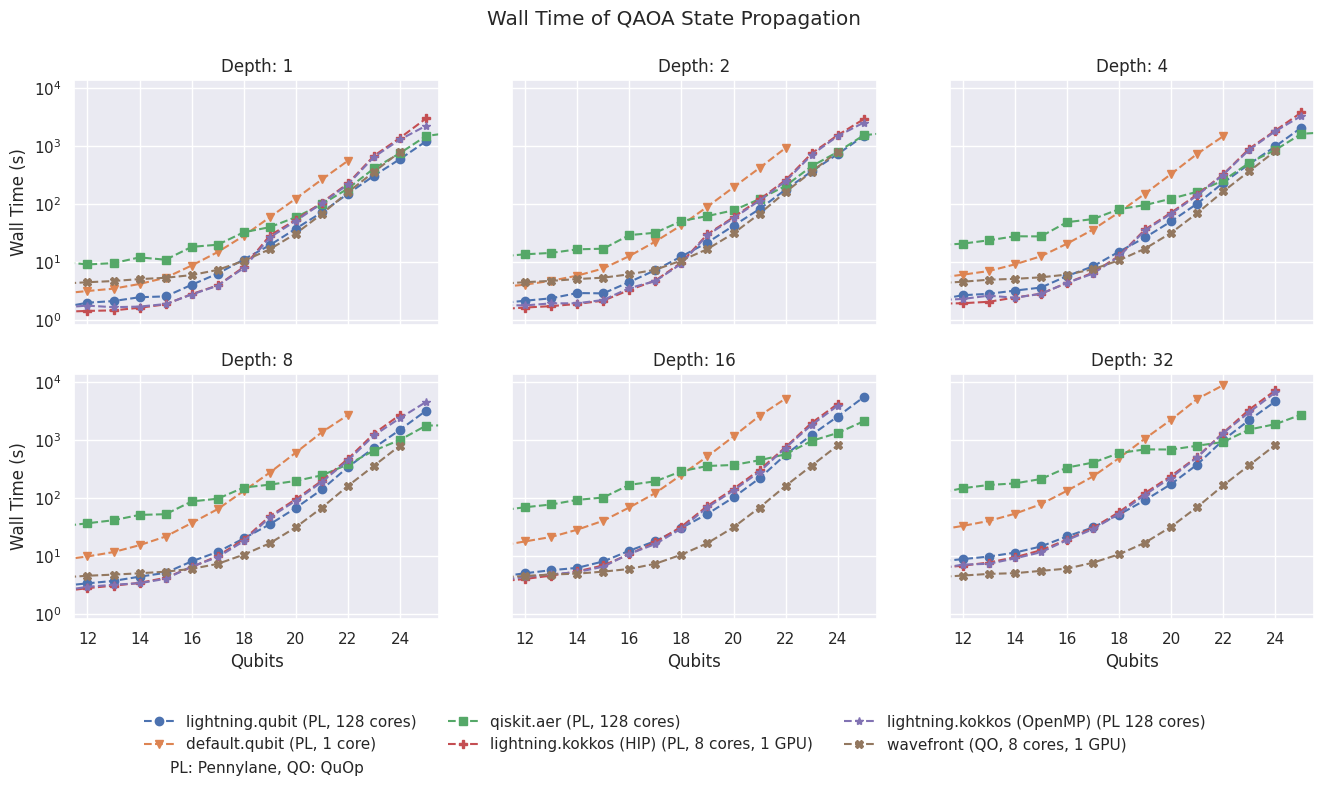

In [329]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7), sharex=True, sharey=True)
depths = [1, 2, 4, 8, 16, 32]
for depth, ax in zip(depths, axes.reshape(-1)):
    walltime_plot(ax, depth)
for i in range(axes.shape[0]):
    axes[i,0].set_ylabel('Wall Time (s)')
for i in range(axes.shape[1]):
    axes[-1,i].set_xlabel('Qubits')


fig.suptitle(f'Wall Time of QAOA State Propagation')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
sns.move_legend(fig, "lower center", bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)
caption="PL: Pennylane, QO: QuOp"
plt.figtext(0.185, -0.11, caption, wrap=True, horizontalalignment='left', fontsize=11)
plt.show()

In [345]:
core_count = {
    'lightning.qubit': 16,
    'qiskit.aer': 2,
    'lightning.kokkos (OpenMP)': 16,
}

labels = ['PL: Pennylane', 'QO: QuOp', 'QK: Qiskit']
def speedup_plot(ax, depth, config = None, efficiency = False, legend_title_pad = 0.08, max_qubits = 25):

    default_df = qaoa_df[((qaoa_df['backend'] == 'default.qubit') & (qaoa_df['depth'] == depth))]
    default_wall_time = default_df.groupby(['qubits'])['wall_time'].mean()
    default_qubits = default_df.groupby(['qubits'])['qubits'].mean()
    default_dict = {qubit: wall_time for qubit, wall_time in zip(default_qubits, default_wall_time)}

    for i, backend in enumerate(qaoa_df['backend'].unique()):

        if backend in core_count.keys():
            cores = core_count[backend]
            backend_df = qaoa_df[(qaoa_df['n_cpus']==cores) & (qaoa_df['backend'] == backend)]
        else:
            backend_df = qaoa_df[qaoa_df['backend'] == backend]

        depth_df = backend_df[backend_df['depth']==depth]
        wall_time = depth_df.groupby(['qubits'])['wall_time'].mean()
        qubits = depth_df.groupby(['qubits'])['qubits'].mean()

        plot_qubits = []
        plot_speedup = []

        for qubits in set(wall_time.keys()).intersection(default_dict.keys()):
            plot_speedup.append(default_dict[qubits]/(wall_time[qubits]))
            plot_qubits.append(qubits)
    
        ax.plot(plot_qubits, plot_speedup, '--', marker = markers[i], label = f'{backend} ({extra_info[backend][0]})', color = f'C{i}')
    ax.set_title(f'Depth: {depth}')
    ax.set_xticks([i for i in range(12, max_qubits + 1, 2)])
    ax.set_xlim(11.5, max_qubits + 0.5)



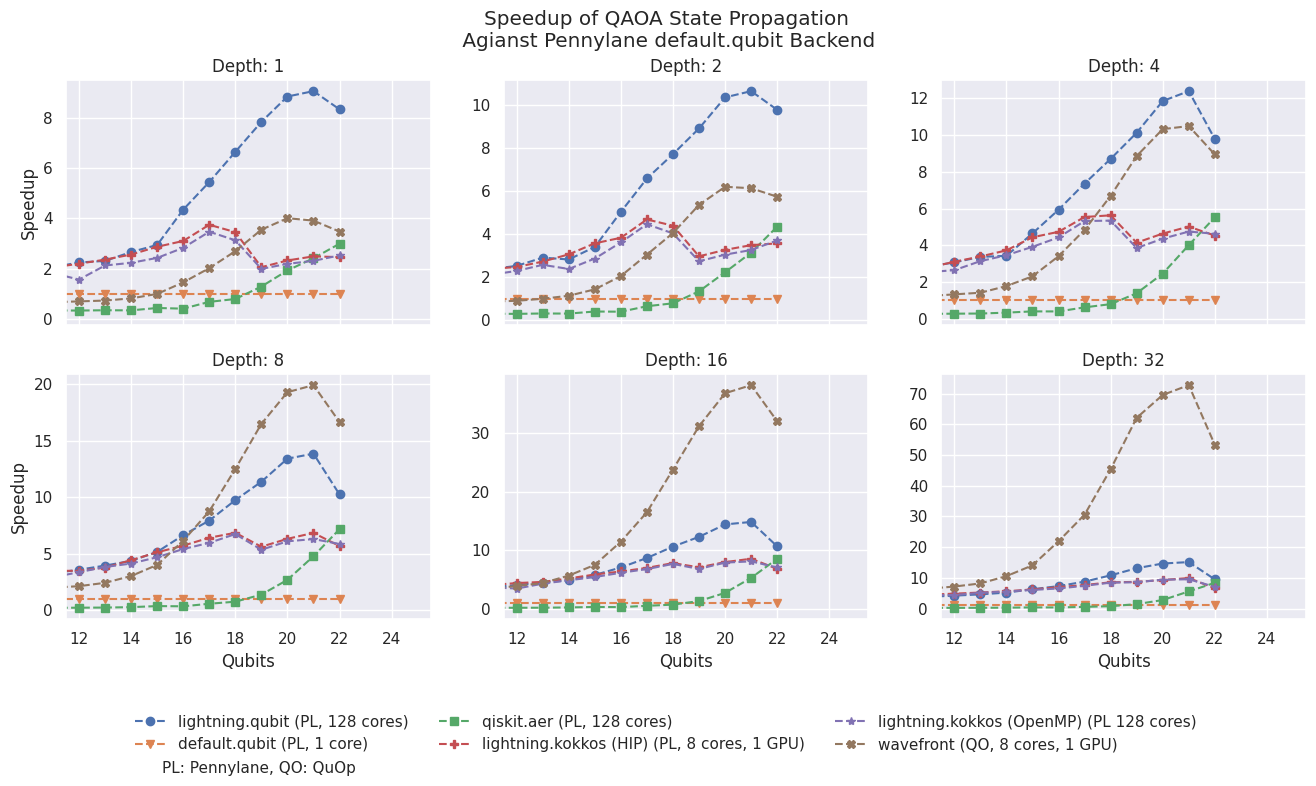

In [347]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7), sharex=True, sharey=False)
depths = [1, 2, 4, 8, 16, 32]
for depth, ax in zip(depths, axes.reshape(-1)):
    speedup_plot(ax, depth)
for i in range(axes.shape[0]):
    axes[i,0].set_ylabel('Speedup')
for i in range(axes.shape[1]):
    axes[-1,i].set_xlabel('Qubits')


fig.suptitle(f'Speedup of QAOA State Propagation\n Agianst Pennylane default.qubit Backend')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
sns.move_legend(fig, "lower center", bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)
caption="PL: Pennylane, QO: QuOp"
plt.figtext(0.185, -0.11, caption, wrap=True, horizontalalignment='left', fontsize=11)
plt.show()